<a href="https://colab.research.google.com/github/Depdx/INF8250AE--Reinforcement-Learning/blob/main/assignement-2/assignement_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Imitation Learning
In this assignment, you will implement the basic components of an Imitation Learning
system, behavior cloning, and DAgger.
## Instructions
- This is an individual assignment. You are not allowed to discuss the problems with other students.
- Part of this assignment will be autograded by gradescope. You can use it as immediate feedback to improve your answers. You can resubmit as many times as you want.
- All your solution, code, analysis, graphs, explanations should be done in this same notebook.
- Please make sure to execute all the cells before you submit the notebook to the gradescope. - You will not get points for the plots if they are not generated already.
- If you have questions regarding the assignment, you can ask for clarifications in
  Piazza. You should use the corresponding tag for this assignment.
- Start Early! Some of the cells can take about an hour to run on CPU. You will need
  time to generate the results.
  
**When Submitting to GradeScope**: Be sure to
1. Submit a .ipynb notebook to the Assignment 2 - Code section on Gradescope.
2. Submit a pdf version of the notebook to the Assignment 2 - Report entry.

Note: You can choose to submit responses in either English or French.

Before starting the assignment, make sure that you have downloaded all the tests related
for the assignment and put them in the appropriate locations. If you run the next cell,
we will set this all up automatically for you in a dataset called public, which will
contain both the data and tests you use.

This assignment has 4 questions. You will learn to:
1. Implement basic components in an Imitation Learning/RL setup.
2. Implement behavior cloning.
3. Implement DAgger.
4. Analyze different aspects of the DAgger algorithm.

In [1]:
!apt update
!apt install -y --no-install-recommends \
        build-essential \
        curl \
        git \
        gnupg2 \
        make \
        cmake \
        ffmpeg \
        swig \
        libz-dev \
        unzip \
        zlib1g-dev \
        libglfw3 \
        libglfw3-dev \
        libxrandr2 \
        libxinerama-dev \
        libxi6 \
        libxcursor-dev \
        libgl1-mesa-dev \
        libgl1-mesa-glx \
        libglew-dev \
        libosmesa6-dev \
        lsb-release \
        ack-grep \
        patchelf \
        wget \
        xpra \
        xserver-xorg-dev \
        ffmpeg
!apt-get install python-opengl -y
!apt install xvfb -y

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]      
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]        
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InReleasem
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]      
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease   
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,342 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease   
Fetched 1,683 kB in 4s (449 kB/s)                                     
Reading package list

In [2]:
!pip install gymnasium[mujoco]
!pip install torch
!pip install tqdm
!pip install matplotlib
!pip install pyvirtualdisplay

In [3]:
!pip install otter-grader
!git clone https://github.com/chandar-lab/INF8250ae-assignments-2023.git public

fatal: destination path 'public' already exists and is not an empty directory.


In [4]:
#@title set up virtual display

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [5]:
import gymnasium as gym
from gymnasium import wrappers
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import os
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [6]:
import otter
grader = otter.Notebook(colab=True, tests_dir='./public/a2/tests')

In [7]:
def plot(
    xs_list,
    means_list,
    stds_list,
    losses_list,
    labels_list=None,
    min=None,
    running_average=5,
):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    if labels_list is None:
        labels_list = [f"Agent {idx}" for idx in range(len(means_list))]
    for xs, means, stds, losses, label in zip(
        xs_list, means_list, stds_list, losses_list, labels_list
    ):
        kernel = np.ones(running_average) / running_average
        means_convolved = np.convolve(means, kernel, mode="same")
        stds_convolved = np.convolve(stds, kernel, mode="same")
        ax[0].plot(xs, means_convolved, label=label)
        ax[0].fill_between(
            xs,
            np.array(means_convolved) - np.array(stds_convolved),
            np.array(means_convolved) + np.array(stds_convolved),
            alpha=0.5,
        )
        ax[1].plot(xs, losses, label=label)
    if min is not None:
        ax[0].set_ylim(min, None)
    ax[0].legend()
    ax[0].set_ylabel("Reward")
    ax[1].set_ylabel("Loss")

    return fig, ax

In [8]:
class ExpertAgent(torch.nn.Module):
    def __init__(self, filename):
        super().__init__()
        self._network = torch.load(filename)
        self._network.eval()

    def get_action(self, obs: np.array):
        """
        Get action from the expert agent.

        Args:
            obs: np.array of shape (state_dim,)
        Returns:
            action: np.array of shape (action_dim,)
        """
        obs = torch.tensor(obs, dtype=torch.float32)
        return self._network(obs).cpu().detach().numpy()

# Q1 Getting started with RL (10 pts)
For this assignment, we will be using the [Ant-v4](https://gymnasium.farama.org/environments/mujoco/ant/) environment. The goal in this environment is to have the "Ant" run as far as it can for 1000
timesteps, with the reward being a linear combination of how far it ran, how long it was
in a "healthy" state, and a penalty for taking actions  that are too large. The actions
control the torque for the motors at each of the 8 joints of the agent.

This environment is part of the [gymnasium](https://gymnasium.farama.org/) package, a
library which provides a standard interface for environments used across many different
RL research projects. For this assignment, you will need to familiar with the interface
provided by the [Env](https://gymnasium.farama.org/api/env/) class. Specifically,
`env.reset()` and `env.step()`. `env.reset()` resets the environment and agent to the
start of the episode. It does not have any required arguments, and it returns `(obs, info)`,
where `obs` is the first observation of the episode, and `info` is a dictionary
containing additional information (you will not need to interact with `info`). To
take actions in the environment, call `env.step`, which takes in an action, and returns
`(obs, reward, terminated, truncated, info)`, where `obs` is the next state, `reward` is
the reward for step just taken, `terminated` refers to whether the episode entered a
terminal state, `truncated` refers to whether the episode was ended before entering a
terminal state, and `info` contains any extra info the environment wants to provide.

## Q1.a: Agent Evaluation (4 pts)
As a warmup and introduction to interactive environments, implement the `evaluate_agent`
function below. It should collect `num_episodes` trajectories in the environment, and
return the mean and standard deviation of the episode returns.

In [9]:
def evaluate_agent(agent, env:gym.Env, num_episodes:int):
    """ Collect num_episodes trajectories for the agent and compute mean and std of the
    rewards. Remember to reset the environment before each episode.
    Args:
        agent: Agent, agent to evaluate
        env: gym.Env, environment to evaluate agent on
        num_episodes: int, number of episodes to evaluate the agent for
    Returns:
        mean_return: float, mean return over the episodes
        std_return: float, standard deviation of the return over the episodes
    """
    returns = []
    for _ in tqdm(range(num_episodes), desc="Evaluating agent", position=1, leave=False):
        obs, info = env.reset()
        terminated = False
        truncated = False
        total_reward = 0
        while not terminated and not truncated:
            action = agent.get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
        returns.append(total_reward)
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    return mean_return, std_return

In [10]:
grader.check("q1a")

q1a results: All test cases passed!

In [11]:
VIDEO_LOCATION = "./content/video"


def show_video():
    mp4list = glob.glob(f"{VIDEO_LOCATION}/*.mp4")
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, "r+b").read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(
            HTML(
                data="""<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>""".format(
                    encoded.decode("ascii")
                )
            )
        )
    else:
        print("Could not find video")


def create_video(vis_env, agent, name_prefix="imitation_learning"):
    vis_env = wrappers.RecordVideo(vis_env, VIDEO_LOCATION, name_prefix=name_prefix)
    evaluate_agent(agent, vis_env, 1)
    vis_env.close_video_recorder()
    show_video()

Let's now visualize what this looks like.

In [12]:
env = gym.make("Ant-v4")
vis_env = gym.make("Ant-v4", render_mode="rgb_array")
a = env.action_space
expert_1mil = ExpertAgent("./public/a2/experts/network_1mil.pt")
mean, std = evaluate_agent(expert_1mil, env, 10)
print(f"Expert mean return: {mean} +/- {std}")
create_video(vis_env, expert_1mil, "expert_1mil")

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Expert mean return: 4385.365070203635 +/- 782.298969847476


Moviepy - Building video /content/content/video/expert_1mil-episode-0.mp4.
Moviepy - Writing video /content/content/video/expert_1mil-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/content/video/expert_1mil-episode-0.mp4


## Q1.b: Replay Buffer (3 pts)
Next, we will implement a replay buffer. In RL, we typically store states, actions,
rewards, next states, and termination for each transition, but for this assignment,
because we are only doing imitation learning (not learning from rewards!), we only need
to store states and actions for each transition. Fill in the missing sample function below.

In [13]:
class ReplayBuffer:
    def __init__(self, max_size=100_000):
        self._max_size = max_size
        self._states = None
        self._actions = None

    def add_rollouts(self, rollouts):
        """
        Add rollouts to the buffer

        Args:
            rollouts: dict, with keys "states" and "actions", with shapes
                (rollout_length, state_dim) and (rollout_length, action_dim)
                respectively.
        """
        if self._states is None:
            self._states = rollouts["states"][-self._max_size :]
            self._actions = rollouts["actions"][-self._max_size :]
        else:
            self._states = np.concatenate([self._states, rollouts["states"]])[
                -self._max_size :
            ]
            self._actions = np.concatenate([self._actions, rollouts["actions"]])[
                -self._max_size :
            ]

    def sample(self, batch_size):
        """
        Sample batch_size elements from the buffer without replacement.

        Args:
            batch_size: int, number of elements to sample
        Returns:
            states: np.array of shape (batch_size, state_dim)
            actions: np.array of shape (batch_size, action_dim)
        """
        if self._states is None or self._actions is None:
            raise ValueError("No data in buffer")

        # TODO: Sample batch_size random elements from self.states and self.actions
        indices = np.random.choice(len(self._states), batch_size, replace=False)
        states = self._states[indices]
        actions = self._actions[indices]
        return states, actions

    def __len__(self):
        return len(self._states) if self._states is not None else 0

In [14]:
grader.check("q1b")

q1b results: All test cases passed!

## Q1.c: Agent (3 pts)
Finally, we come to the agent, which is the entity that selects actions to perform in
the environment. We've provided the network architecture below. It's up to you to fill
in the agent's `forward` and `get_action` functions. They do similar things, but keep in
mind the expected function signature!

In [15]:
class Agent(torch.nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self._network = torch.nn.Sequential(
            torch.nn.Linear(obs_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, action_dim),
        )

    def forward(self, obs_tensor: torch.Tensor):
        """
        Returns the actions for a batch of observations.

        Args:
            obs_tensor: torch.Tensor of shape (batch_size, obs_dim)
        Returns:
            action_tensor: torch.Tensor of shape (batch_size, action_dim)
        """
        return self._network(obs_tensor)

    def get_action(self, obs: np.ndarray) -> np.ndarray:
        """
        Get action from the agent for a single observation.

        Args:
            obs: np.ndarray of shape (obs_dim,)
        Returns:
            action: np.ndarray of shape (action_dim,)
        """

        obs = torch.tensor(obs, dtype=torch.float32)
        return self.forward(obs).cpu().detach().numpy()

In [16]:
grader.check("q1c")

q1c results: All test cases passed!

# Q2: Behavior cloning (20 pts)

## Q2.a Implement Behavior Cloning (15 pts)
We now come to our first Imitation Learning algorithm: behavior cloning.
Run `steps` steps of gradient descent using the `optimizer` with the predictions
coming from the `agent` and input and targets coming from the `buffer` in batch sizes of
`batch_size`. Since this is a continuous action space, we will be using a regression
loss, specifically average mean squared error:
$l(\mathbf{x}, \mathbf{y}) = \frac{\sum_{m=1}^M\sum_{n=1}^N (x_n^m - y_n^m)^2}{N\times
M}$, where $M$ is the batch size, $N$ is the dimension of each sample, and $x_n^m$
refers to the $n$-th dimension of the $m$-th sample.


In [17]:
def behavior_cloning(agent, optimizer, buffer, batch_size=128, steps=1000):
    """
    Args:
        agent: Agent, agent to train
        optimizer: torch.optim.Optimizer, optimizer to use
        buffer: ReplayBuffer, buffer to sample from
        batch_size: int, batch size
        steps: int, number of steps to train
    Returns:
        loss: float, Average loss over the last 5 steps
    """

    losses = []
    # TODO: Implement the behavior cloning training loop
    # Hint: Store the loss values in losses list to compute the final average over the
    # last 5 steps
    # Hint: Take a look at torch.nn.functional for useful functions for computing the
    # loss
    for step in tqdm(range(steps), desc="Training agent", position=1, leave=False):
        states, actions = buffer.sample(batch_size)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        actions_pred = agent(states)
        loss = torch.nn.functional.mse_loss(actions_pred, actions)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return np.mean(losses[-5:])

In [18]:
grader.check("q2.a")

q2.a results: All test cases passed!

<!-- BEGIN QUESTION -->

## Q2.b Run Behavior Cloning (5 pts)
Run behavior cloning on the curated data given above for 1000 steps. Then evaluate the agent for
10 episodes, reporting the mean and standard deviation. You should get at least 50% of
the average expert return.

In [29]:
with open("./public/a2/expert_data/expert_data_Ant-v4.pkl", "rb") as f:
    data = pickle.load(f)
    states = np.concatenate([trajectory["observation"][:, :27] for trajectory in data])
    actions = np.concatenate([trajectory["action"] for trajectory in data])
    data_average_reward = np.mean([np.sum(trajectory["reward"]) for trajectory in data])
print(f"Average expert return: {data_average_reward}")

Average expert return: 4713.6533203125


In [30]:
BATCH_SIZE = 128
STEPS = 1000
bc_agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
optimizer = torch.optim.Adam(bc_agent.parameters(), lr=5e-3)
bc_buffer = ReplayBuffer()

bc_buffer.add_rollouts({"states": states, "actions": actions})
loss = behavior_cloning(bc_agent, optimizer, bc_buffer, batch_size=BATCH_SIZE, steps=STEPS)
mean, std = evaluate_agent(bc_agent, env, 10)

print(
    f"The agent trained on the curated dataset has an average reward of {mean} +/- {std}"
)
create_video(vis_env, bc_agent, name_prefix="ant_curated")

The agent trained on the curated dataset has an average reward of 4401.394915087339 +/- 170.5531626853591


Moviepy - Building video /content/content/video/ant_curated-episode-0.mp4.
Moviepy - Writing video /content/content/video/ant_curated-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/content/video/ant_curated-episode-0.mp4


<!-- END QUESTION -->

# Q3 DAgger Implementation (30 pts)
Finally, we look at the [Dataset Aggregation (DAgger)
algorithm](https://www.ri.cmu.edu/pub_files/2011/4/Ross-AISTATS11-NoRegret.pdf). Each
iteration of this algorithm involves dataset collection, data relabeling with an expert
policy, and behavior cloning.

In [21]:
def relabel_with_expert(states, expert_agent):
    """
    Args:
        states: np.array of shape (batch_size, state_dim)
        expert_agent: ExpertAgent
    Returns:
        actions: np.array of shape (batch_size, action_dim)
    """
    actions = []

    # TODO: Loop through the states, and get the expert action
    # for each state
    # Hint: Use expert_agent.get_action

    for state in states:
        action = expert_agent.get_action(state)
        actions.append(action)

    return np.array(actions)


In [22]:
def collect_rollouts(env, agent, n_to_collect=1000):
    """
    Args:
        env: gym.Env
        agent: Agent
        n_to_collect: int, number of states to collect
    Returns:
        states: np.array of shape (n_to_collect, state_dim)
        actions: np.array of shape (n_to_collect, action_dim)
    """
    states = []
    actions = []
    state, info = env.reset()
    terminated = False
    truncated = False

    ### TODO: Collect rollouts until we have n_to_collect states
    # Hint: Remember to reset the environment when a rollout is finished

    for _ in tqdm(range(n_to_collect), desc="Collecting rollouts", position=1, leave=False):
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        states.append(state)
        actions.append(action)
        state = next_state
        if terminated or truncated:
            state, info = env.reset()

    return np.array(states), np.array(actions)


In [23]:
def seed_data(env, expert_agent, buffer, n_to_collect=1000):
    """
    Collects rollouts using the expert agent and adds them to the buffer.

    Args:
        env: gym.Env
        expert_agent: ExpertAgent
        buffer: ReplayBuffer
        n_to_collect: int, number of samples to collect
    """

    states, actions = collect_rollouts(env, expert_agent, n_to_collect)
    buffer.add_rollouts({"states": states, "actions": actions})

In [24]:
grader.check("q3")

q3 results: All test cases passed!

In [25]:
def dagger_iteration(
    agent,
    optimizer,
    expert_agent,
    env,
    buffer,
    n_to_collect,
    steps=1000,
    batch_size=128,
):
    """
    Implements one iteration of the DAgger algorithm. Collects the rollouts using the
    agent, relabels them using the expert, and trains the agent for `steps` steps using
    behavior cloning.

    Args:
        agent: Agent
        optimizer: torch.optim.Optimizer
        expert_agent: ExpertAgent
        env: gym.Env
        buffer: ReplayBuffer
        n_to_collect: int, number of samples to collect
        steps: int, number of steps to train
        batch_size: int, batch size
    Returns:
        loss: float, Average loss over the last 5 steps of behavior
            cloning
    """

    seed_data(env, expert_agent, buffer, n_to_collect)
    loss = behavior_cloning(agent, optimizer, buffer, batch_size, steps)

    return loss

In [26]:
def dagger(
    agent,
    optimizer,
    expert_agent,
    env,
    buffer,
    collect_per_iteration=2000,
    n_iterations=10,
    gradient_steps=1000,
    batch_size=128,
    n_episodes_eval=10,
):
    """
    Runs the DAgger algorithm for `n_iterations` iterations. The loss from each
    iteration is stored and returned. After each iteration, the agent is evaluated for
    `n_episodes_eval` episodes. The mean and std of the rewards are stored and returned.

    Args:
        agent: Agent
        optimizer: torch.optim.Optimizer
        expert_agent: ExpertAgent
        env: gym.Env
        buffer: ReplayBuffer
        collect_per_iteration: int, number of samples to collect per iteration
        n_iterations: int, number of DAgger iterations
        gradient_steps: int, number of steps to train the agent for per iteration
        batch_size: int, batch size
        n_episodes_eval: int, number of episodes to evaluate the agent for
    Returns:
        losses: list of floats, losses from each DAgger iteration
        means: list of floats, mean rewards from each DAgger iteration
        stds: list of floats, std of rewards from each DAgger iteration
    """
    losses, means, stds = [], [], []

    ### TODO: Implement the DAgger algorithm
    # Hint: It might be helpful when running stuff later on to also print
    # which iteration of DAgger you are on
    for _ in tqdm(range(n_iterations), desc="DAgger iteration", position=0):
        loss = dagger_iteration(
            agent,
            optimizer,
            expert_agent,
            env,
            buffer,
            collect_per_iteration,
            gradient_steps,
            batch_size,
        )
        losses.append(loss)
        mean, std = evaluate_agent(agent, env, n_episodes_eval)
        means.append(mean)
        stds.append(std)

    return losses, means, stds


<!-- END QUESTION -->

# Q4 Analyzing DAgger
Now, you will perform various experiments to test and analyze the performance of
behavior cloning and DAgger.

<!-- BEGIN QUESTION -->

## Q4.a: DAgger with policy drift
You currently have access to two agents: the `expert_1mil` policy that we provided you,
and the `bc_agent` learned through behavior cloning the curated expert data. Starting from
the same agent and replay buffer as the behavior cloning experiment above, run 15
iterations of DAgger with the `expert_1mil` policy. Then, reset the agent and buffer, do
15 iterations of DAgger with the `expert_1mil` policy starting from a random agent and
empty replay buffer. Plot the loss and average mean with standard deviation using the
plotting function above.

DAgger iteration: 100%|██████████| 15/15 [02:43<00:00, 10.87s/it]


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: ylabel='Reward'>, <Axes: ylabel='Loss'>], dtype=object))

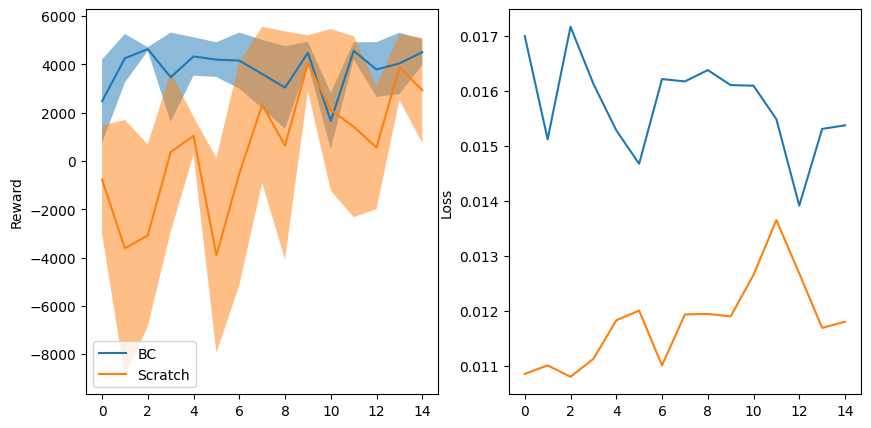

In [45]:
# Run DAgger starting from agent pretrained on curated data data
expert = ExpertAgent("./public/a2/experts/network_1mil.pt")
agent = bc_agent
buffer = bc_buffer
optimizer = torch.optim.Adam(agent.parameters(), lr=5e-3)
losses_bc, means_bc, stds_bc = dagger(
    agent, optimizer, expert, env, buffer, 2000, 15, 2000, 128, 10
)

# Run DAgger starting from scratch, using the same expert
agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
buffer = ReplayBuffer()
optimizer = torch.optim.Adam(agent.parameters(), lr=5e-3)
seed_data(env, expert, buffer, 2000)
losses_scratch, means_scratch, stds_scratch = dagger(
    agent, optimizer, expert, env, buffer, 2000, 15, 2000, 128, 10
)
plot(
    [np.arange(len(losses_bc)), np.arange(len(losses_scratch))],
    [means_bc, means_scratch],
    [stds_bc, stds_scratch],
    [losses_bc, losses_scratch],
    ["BC", "Scratch"],
    running_average=1,
)

### Analysis
The results of the experiment show interesting dynamics between the Behavior Cloning (BC) and DAgger approaches. In the BC approach, we observed a higher reward from the outset, which suggests that the model quickly captures the expert's behavior. This higher reward plateau indicates that the BC agent performs well in mimicking the expert's actions. On the other hand, the DAgger approach, when started from the same initial conditions, began with a lower reward compared to BC. However, over the course of 15 iterations, it gradually converged to the same reward plateau as BC. This demonstrates the power of DAgger in iteratively aggregating and improving the dataset, allowing the agent to progressively match the expert's performance. In terms of loss, it's intriguing to note that the DAgger approach, when started from scratch, exhibited a lower loss than BC. This suggests that DAgger's iterative data collection and aggregation process may help in reducing the policy's loss and improving its overall performance, even when initialized randomly.

<!-- END QUESTION -->

For the rest of this assignment, we will be using a new expert agent. Evaluate and visualize it below.

In [46]:
expert_2mil = ExpertAgent("./public/a2/experts/network_2mil.pt")
mean, std = evaluate_agent(expert_2mil, env, 10)
print(f"Expert mean return: {mean} +/- {std}")
create_video(vis_env, expert_2mil, "expert_2mil")

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Expert mean return: 5739.237095163596 +/- 354.64819759415326


Moviepy - Building video /content/content/video/expert_2mil-episode-0.mp4.
Moviepy - Writing video /content/content/video/expert_2mil-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/content/video/expert_2mil-episode-0.mp4


<!-- BEGIN QUESTION -->

# Q4.b Exploring the effect of the effect of the strength of the expert on DAgger
We now look at how the strength of the expert affects our imitation learned algorithm.
The `expert_1mil` and `expert_2mil` are both policies from the same training run, except
the `expert_1mil` was trained for 1 million steps and `expert_2mil` was trained for 2 million steps.

In [47]:
N_ITERS = 50
N_DATA_PER_ITER = 2000
N_GRADIENT_STEPS = 2000
expert_strength_data = {
    "all_means": [],
    "all_stds": [],
    "all_losses": [],
    "all_xs": [],
}
for expert in [expert_1mil, expert_2mil]:
    agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
    optimizer = torch.optim.Adam(agent.parameters(), lr=5e-3)
    buffer = ReplayBuffer()
    seed_data(env, expert, buffer, 2000)

    # TODO: Run DAgger for the given expert
    losses, means, stds = dagger(
        agent, optimizer, expert, env, buffer, 2000, 50, 2000, 128, 10
    )

    xs = np.arange(N_ITERS) + 1
    expert_strength_data["all_xs"].append(xs)
    expert_strength_data["all_means"].append(means)
    expert_strength_data["all_stds"].append(stds)
    expert_strength_data["all_losses"].append(losses)

DAgger iteration: 100%|██████████| 50/50 [10:34<00:00, 12.68s/it]


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: ylabel='Reward'>, <Axes: ylabel='Loss'>], dtype=object))

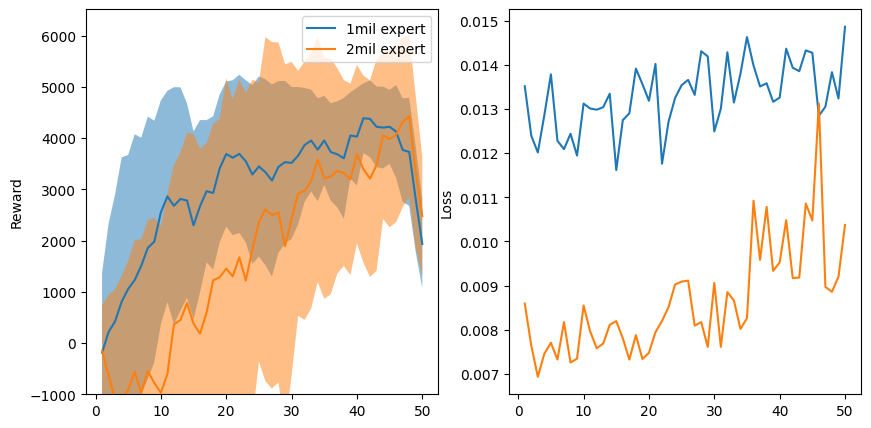

In [48]:
plot(
    expert_strength_data["all_xs"],
    expert_strength_data["all_means"],
    expert_strength_data["all_stds"],
    expert_strength_data["all_losses"],
    [f"{expert} expert" for expert in ["1mil", "2mil"]],
    min=-1000,
)

### Analysis

The intriguing results of this experiment suggest that the relationship between the training duration of an expert policy and its effectiveness in imitation learning is not straightforward. Surprisingly, the expert_1mil, which was trained for a shorter duration, exhibited a higher reward than the expert_2mil, which had twice as much training experience. This result implies that a longer training duration does not always guarantee better initial performance, and the quality of the expert's policy can be influenced by various factors beyond training time. Despite the initial reward difference, both experts eventually converged in terms of reward. This convergence indicates that, over time, DAgger was able to adapt and learn from both experts, aligning its performance with the expert policies. This suggests that the choice of expert strength might have a more pronounced impact on early learning phases than on long-term convergence. Notably, the expert_2mil policy exhibited a lower loss than the expert_1mil. This indicates that the longer training duration led to a more refined and precise expert policy, as evidenced by the lower loss. However, DAgger's ability to narrow this loss gap and converge to a similar performance level for both experts highlights its adaptability and capacity for closing the gap between expert policies, even when they start with varying degrees of expertise.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Q4.c Exploring the effect of the number of iterations on DAgger
We will now look at how the frequency of the number of DAgger iterations affects the
performance. To make it fair, make sure to control for the total amount of data and
gradient steps that will be taken by the algorithm.

In [49]:
TOTAL_DATA = 100_000
TOTAL_GRADIENT_STEPS = 100_000
n_iters_data = {
    "all_means": [],
    "all_stds": [],
    "all_losses": [],
    "all_xs": [],
}
expert = ExpertAgent("./public/a2/experts/network_2mil.pt")
for n_iters in [5, 25, 50, 100, 200]:
    agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
    optimizer = torch.optim.Adam(agent.parameters(), lr=5e-3)
    buffer = ReplayBuffer()
    seed_data(env, expert, buffer, 2000)

    # TODO: Run DAgger for n_iters iterations
    losses, means, stds = dagger(
        agent, optimizer, expert, env, buffer, 2000, n_iters, 2000, 128, 10
    )
    xs = 100_000 / n_iters * (np.arange(n_iters) + 1)
    n_iters_data["all_xs"].append(xs)
    n_iters_data["all_means"].append(means)
    n_iters_data["all_stds"].append(stds)
    n_iters_data["all_losses"].append(losses)

DAgger iteration: 100%|██████████| 200/200 [56:29<00:00, 16.95s/it]


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: ylabel='Reward'>, <Axes: ylabel='Loss'>], dtype=object))

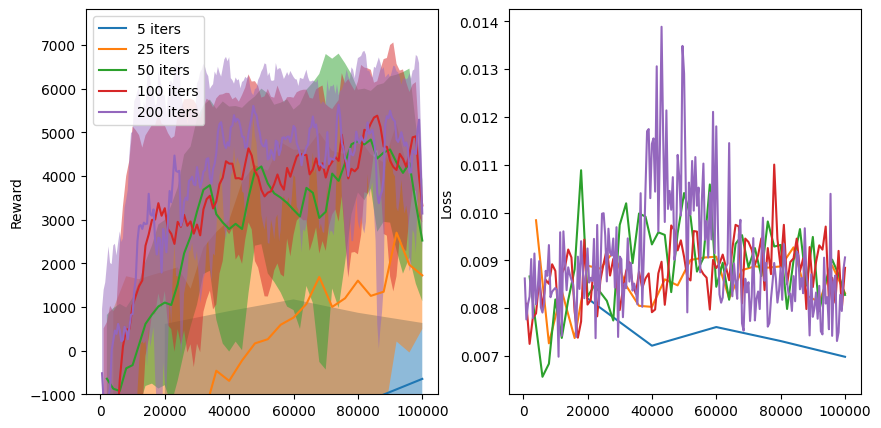

In [50]:
plot(
    n_iters_data["all_xs"],
    n_iters_data["all_means"],
    n_iters_data["all_stds"],
    n_iters_data["all_losses"],
    [f"{n_iters} iters" for n_iters in [5, 25, 50, 100, 200]],
    min=-1000,
)

### Analysis

The results of this experiment provide valuable insights into the relationship between the number of DAgger iterations and the performance of the reinforcement learning algorithm. The findings indicate a clear trend that the higher the number of DAgger iterations, the higher the mean reward achieved. This suggests that additional iterations contribute positively to the learning process, allowing the agent to refine its policy and improve its performance over time. However, it's essential to consider the computational cost associated with each iteration. As the number of iterations increases, so does the computational burden. This trade-off between the number of iterations and the mean reward highlights the need to balance computational resources with learning effectiveness. Notably, there appears to be a diminishing returns effect on the mean reward as the number of iterations increases. The gap in mean reward between 5 and 25 iterations is substantial, indicating a significant improvement initially. However, beyond 50 iterations, the increase in mean reward becomes less pronounced, suggesting that additional iterations may yield diminishing benefits. In terms of loss, it's interesting to observe that the 200-iteration scenario exhibits higher variance compared to others. This suggests that more iterations might introduce instability in the learning process, even though it leads to higher mean rewards. On the other hand, the 5-iteration scenario has the lowest loss, indicating a potentially more stable learning curve. Overall, these results emphasize the importance of striking a balance between the number of DAgger iterations and the computational cost, with the recognition that there may be diminishing returns in terms of mean reward beyond a certain point. Additionally, it's crucial to consider the trade-off between mean reward and loss variance when selecting the appropriate number of iterations for a given reinforcement learning task.